In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random
import re

2023-02-24 11:56:13.826471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Définition des fonctions utiles

In [2]:
# Check if a variable is a number or represents a number.
def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

# Check if a variable is an integer or represents an integer.
def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

# Check if a variable is a a finite number or represents a finite number.
def is_finite_number(x):
    if is_number(x):
        return np.isfinite(float(x))
    else:
        return False

# Compare normalized strings.
def compare_strings(x, y):
    try:
        return str(x).strip().casefold()==str(y).strip().casefold()
    except AttributeError: # For Python 2.x compatibility
        return str(x).strip().lower()==str(y).strip().lower()

# Find patient data files.
def find_patient_files(data_folder):
    # Find patient files.
    filenames = list()
    for f in sorted(os.listdir(data_folder)):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.txt':
            filename = os.path.join(data_folder, f)
            filenames.append(filename)

    # To help with debugging, sort numerically if the filenames are integers.
    roots = [os.path.split(filename)[1][:-4] for filename in filenames]
    if all(is_integer(root) for root in roots):
        filenames = sorted(filenames, key=lambda filename: int(os.path.split(filename)[1][:-4]))
        
    return filenames

# Load patient data as a string.
def load_patient_data(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data

# Load a WAV file.
def load_wav_file(filename):
    frequency, recording = sp.io.wavfile.read(filename)
    return recording, frequency

# Load recordings.
def load_recordings_AV(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        if 'AV.wav' in filename:
            recording, frequency = load_wav_file(filename)
            recordings.append(recording)
            frequencies.append(frequency)

    if get_frequencies:
        return recordings, frequencies
    else:
        return recordings

# Load recordings.
def load_recordings(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        recording, frequency = load_wav_file(filename)
        recordings.append(recording)
        frequencies.append(frequency)

    if get_frequencies:
        return recordings, frequencies
    else:
        return recordings

# Get patient ID from patient data.
def get_patient_id(data):
    patient_id = None
    for i, l in enumerate(data.split('\n')):
        if i==0:
            try:
                patient_id = l.split(' ')[0]
            except:
                pass
        else:
            break
    return patient_id

# Get number of recording locations from patient data.
def get_num_locations(data):
    num_locations = None
    for i, l in enumerate(data.split('\n')):
        if i==0:
            try:
                num_locations = int(l.split(' ')[1])
            except:
                pass
        else:
            break
    return num_locations

# Get frequency from patient data.
def get_frequency(data):
    frequency = None
    for i, l in enumerate(data.split('\n')):
        if i==0:
            try:
                frequency = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    return frequency

# Get recording locations from patient data.
def get_locations(data):
    num_locations = get_num_locations(data)
    locations = list()
    for i, l in enumerate(data.split('\n')):
        entries = l.split(' ')
        if i==0:
            pass
        elif 1<=i<=num_locations:
            locations.append(entries[0])
        else:
            break
    return locations

# Get age from patient data.
def get_age(data):
    age = None
    for l in data.split('\n'):
        if l.startswith('#Age:'):
            try:
                age = l.split(': ')[1].strip()
            except:
                pass
    return age

# Get sex from patient data.
def get_sex(data):
    sex = None
    for l in data.split('\n'):
        if l.startswith('#Sex:'):
            try:
                sex = l.split(': ')[1].strip()
            except:
                pass
    return sex

# Get height from patient data.
def get_height(data):
    height = None
    for l in data.split('\n'):
        if l.startswith('#Height:'):
            try:
                height = float(l.split(': ')[1].strip())
            except:
                pass
    return height

# Get weight from patient data.
def get_weight(data):
    weight = None
    for l in data.split('\n'):
        if l.startswith('#Weight:'):
            try:
                weight = float(l.split(': ')[1].strip())
            except:
                pass
    return weight

# Get pregnancy status from patient data.
def get_pregnancy_status(data):
    is_pregnant = None
    for l in data.split('\n'):
        if l.startswith('#Pregnancy status:'):
            try:
                is_pregnant = bool(sanitize_binary_value(l.split(': ')[1].strip()))
            except:
                pass
    return is_pregnant

# Get murmur from patient data.
def get_murmur(data):
    murmur = None
    for l in data.split('\n'):
        if l.startswith('#Murmur:'):
            try:
                murmur = l.split(': ')[1]
            except:
                pass
    if murmur is None:
        raise ValueError('No murmur available. Is your code trying to load labels from the hidden data?')
    return murmur

# Get outcome from patient data.
def get_outcome(data):
    outcome = None
    for l in data.split('\n'):
        if l.startswith('#Outcome:'):
            try:
                outcome = l.split(': ')[1]
            except:
                pass
    if outcome is None:
        raise ValueError('No outcome available. Is your code trying to load labels from the hidden data?')
    return outcome

# Sanitize binary values from Challenge outputs.
def sanitize_binary_value(x):
    x = str(x).replace('"', '').replace("'", "").strip() # Remove any quotes or invisible characters.
    if (is_finite_number(x) and float(x)==1) or (x in ('True', 'true', 'T', 't')):
        return 1
    else:
        return 0

# Santize scalar values from Challenge outputs.
def sanitize_scalar_value(x):
    x = str(x).replace('"', '').replace("'", "").strip() # Remove any quotes or invisible characters.
    if is_finite_number(x) or (is_number(x) and np.isinf(float(x))):
        return float(x)
    else:
        return 0.0

# Save Challenge outputs.
def save_challenge_outputs(filename, patient_id, classes, labels, probabilities):
    # Format Challenge outputs.
    patient_string = '#{}'.format(patient_id)
    class_string = ','.join(str(c) for c in classes)
    label_string = ','.join(str(l) for l in labels)
    probabilities_string = ','.join(str(p) for p in probabilities)
    output_string = patient_string + '\n' + class_string + '\n' + label_string + '\n' + probabilities_string + '\n'

    # Write the Challenge outputs.
    with open(filename, 'w') as f:
        f.write(output_string)

# Load Challenge outputs.
def load_challenge_outputs(filename):
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            if i==0:
                patient_id = l.replace('#', '').strip()
            elif i==1:
                classes = tuple(entry.strip() for entry in l.split(','))
            elif i==2:
                labels = tuple(sanitize_binary_value(entry) for entry in l.split(','))
            elif i==3:
                probabilities = tuple(sanitize_scalar_value(entry) for entry in l.split(','))
            else:
                break
    return patient_id, classes, labels, probabilities

# Définition des fonction de processing des data

In [3]:
# Create train and test set.
def create_train_valtest_set(data_folder,verbose):
    # Find data files.
    if verbose >= 1:
        print('Finding data files...')
    
    #print("Hello world!")

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)

    if num_patient_files==0:
        raise Exception('No data was provided.')

    # Extract the features and labels.
    if verbose >= 1:
        print('Extracting features and labels from the Challenge data...')

    #murmur_classes = ['Present', 'Unknown', 'Absent']
    murmur_classes = ['Present', 'Absent']
    num_murmur_classes = len(murmur_classes)

    """
    outcome_classes = ['Abnormal', 'Normal']
    num_outcome_classes = len(outcome_classes)
    """

    features = list()
    murmurs = list()
    #outcomes = list()

    for i in range(num_patient_files):
        if verbose >= 2:
            print('    {}/{}...'.format(i+1, num_patient_files))

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files[i])
        #print("HELLO")
        current_recordings = load_recordings(data_folder, current_patient_data)
        #print("current_recordings : ",current_recordings)
        
        # Extract features.
        current_features = get_features_wav(current_patient_data,current_recordings)
        

        # Extract labels and use one-hot encoding.
        current_murmur = np.zeros(num_murmur_classes, dtype=int)
        murmur = get_murmur(current_patient_data)
        if murmur in murmur_classes:
            j = murmur_classes.index(murmur)
            current_murmur[j] = 1
        
        # Takes only in account patient that have a "Present" or "Absent" murmur.
        if murmur != "Unknown":
            murmurs.append(current_murmur)
            features.append(current_features)
        

    #features = np.vstack(features)
    #murmurs = np.vstack(murmurs)


    X_train, X_test, y_train, y_test = train_test_split(features, murmurs, test_size=0.15, random_state=42)

    #outcomes = np.vstack(outcomes)
    return X_train, X_test, y_train, y_test


# Create train and test set.
def create_train_test_set(data_folder,verbose):
    # Find data files.
    if verbose >= 1:
        print('Finding data files...')
        #print("Hello world!")

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)

    if num_patient_files==0:
        raise Exception('No data was provided.')

    # Extract the features and labels.
    if verbose >= 1:
        print('Extracting features and labels from the Challenge data...')

    #murmur_classes = ['Present', 'Unknown', 'Absent']
    murmur_classes = ['Present', 'Absent']
    num_murmur_classes = len(murmur_classes)

    """
    outcome_classes = ['Abnormal', 'Normal']
    num_outcome_classes = len(outcome_classes)
    """

    features = list()
    murmurs = list()
    #outcomes = list()

    for i in range(num_patient_files):
        if verbose >= 2:
            print('    {}/{}...'.format(i+1, num_patient_files))

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files[i])

        #current_recordings = load_recordings(data_folder, current_patient_data)

        # Extract features.
        current_features = get_features_csv(current_patient_data)
        

        # Extract labels and use one-hot encoding.
        current_murmur = np.zeros(num_murmur_classes, dtype=int)
        murmur = get_murmur(current_patient_data)
        if murmur in murmur_classes:
            j = murmur_classes.index(murmur)
            current_murmur[j] = 1
        
        # Takes only in account patient that have a "Present" or "Absent" murmur.
        if murmur != "Unknown":
            murmurs.append(current_murmur)
            features.append(current_features)
        

    #features = np.vstack(features)
    #murmurs = np.vstack(murmurs)


    X_train, X_test, y_train, y_test = train_test_split(features, murmurs, test_size=0.2, random_state=42)

    #outcomes = np.vstack(outcomes)
    return X_train, X_test, y_train, y_test


# Train your model on data from csv.
def train_challenge_model_csv(model_folder,features,murmurs, verbose):
    
    # Create a folder for the model if it does not already exist.
    os.makedirs(model_folder, exist_ok=True)

    # Train the model.
    if verbose >= 1:
        print('Training model...')

    # Define parameters for random forest classifier.
    n_estimators   = 123  # Number of trees in the forest.
    max_leaf_nodes = 45   # Maximum number of leaf nodes in each tree.
    random_state   = 6789 # Random state; set for reproducibility.

    imputer = SimpleImputer().fit(features)
    features = imputer.transform(features)
    murmur_classifier = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=random_state).fit(features, murmurs)
    #outcome_classifier = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=random_state).fit(features, outcomes)
    

    # Save the model.
    murmur_classes = ['Present', 'Absent']
    save_challenge_model_csv(model_folder, imputer, murmur_classes, murmur_classifier)

    if verbose >= 1:
        print('Done.')
        return murmur_classifier


# Train your model on both data from csv and recordings.
def train_challenge_model(data_folder, model_folder, verbose):
    # Find data files.
    if verbose >= 1:
        print('Finding data files...')

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)

    if num_patient_files==0:
        raise Exception('No data was provided.')

    # Create a folder for the model if it does not already exist.
    os.makedirs(model_folder, exist_ok=True)

    # Extract the features and labels.
    if verbose >= 1:
        print('Extracting features and labels from the Challenge data...')

    murmur_classes = ['Present', 'Unknown', 'Absent']
    num_murmur_classes = len(murmur_classes)
    outcome_classes = ['Abnormal', 'Normal']
    num_outcome_classes = len(outcome_classes)

    features = list()
    murmurs = list()
    outcomes = list()

    for i in range(num_patient_files):
        if verbose >= 2:
            print('    {}/{}...'.format(i+1, num_patient_files))

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files[i])

        current_recordings = load_recordings(data_folder, current_patient_data)

        # Extract features.
        current_features = get_features(current_patient_data, current_recordings)
        features.append(current_features)

        # Extract labels and use one-hot encoding.
        current_murmur = np.zeros(num_murmur_classes, dtype=int)
        murmur = get_murmur(current_patient_data)
        if murmur in murmur_classes:
            j = murmur_classes.index(murmur)
            current_murmur[j] = 1
        murmurs.append(current_murmur)

        current_outcome = np.zeros(num_outcome_classes, dtype=int)
        outcome = get_outcome(current_patient_data)
        if outcome in outcome_classes:
            j = outcome_classes.index(outcome)
            current_outcome[j] = 1
        outcomes.append(current_outcome)
        

    features = np.vstack(features)
    murmurs = np.vstack(murmurs)
    outcomes = np.vstack(outcomes)
    print(len(features))
    print("Patient 2530, element 1 : ",features[900])

    # Train the model.
    if verbose >= 1:
        print('Training model...')

    # Define parameters for random forest classifier.
    n_estimators   = 123  # Number of trees in the forest.
    max_leaf_nodes = 45   # Maximum number of leaf nodes in each tree.
    random_state   = 6789 # Random state; set for reproducibility.

    imputer = SimpleImputer().fit(features)
    features = imputer.transform(features)
    #print(len(features))
    #print("Patient 2530, element 1 : ",len(features[900]))
    murmur_classifier = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=random_state).fit(features, murmurs)
    outcome_classifier = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=random_state).fit(features, outcomes)
    

    # Save the model.
    save_challenge_model(model_folder, imputer, murmur_classes, murmur_classifier, outcome_classes, outcome_classifier)

    if verbose >= 1:
        print('Done.')

# Load your trained model. This function is *required*. You should edit this function to add your code, but do *not* change the
# arguments of this function.
def load_challenge_model(model_folder, verbose):
    filename = os.path.join(model_folder, 'model.sav')
    return joblib.load(filename)

# Run your trained model. This function is *required*. You should edit this function to add your code, but do *not* change the
# arguments of this function.
def run_challenge_model(model, data, recordings, verbose):
    imputer = model['imputer']
    murmur_classes = model['murmur_classes']
    murmur_classifier = model['murmur_classifier']
    outcome_classes = model['outcome_classes']
    outcome_classifier = model['outcome_classifier']

    # Load features.
    features = get_features(data, recordings)

    # Impute missing data.
    features = features.reshape(1, -1)
    features = imputer.transform(features)

    # Get classifier probabilities.
    murmur_probabilities = murmur_classifier.predict_proba(features)
    murmur_probabilities = np.asarray(murmur_probabilities, dtype=np.float32)[:, 0, 1]
    outcome_probabilities = outcome_classifier.predict_proba(features)
    outcome_probabilities = np.asarray(outcome_probabilities, dtype=np.float32)[:, 0, 1]

    # Choose label with highest probability.
    murmur_labels = np.zeros(len(murmur_classes), dtype=np.int_)
    idx = np.argmax(murmur_probabilities)
    murmur_labels[idx] = 1
    outcome_labels = np.zeros(len(outcome_classes), dtype=np.int_)
    idx = np.argmax(outcome_probabilities)
    outcome_labels[idx] = 1

    # Concatenate classes, labels, and probabilities.
    classes = murmur_classes + outcome_classes
    labels = np.concatenate((murmur_labels, outcome_labels))
    probabilities = np.concatenate((murmur_probabilities, outcome_probabilities))

    return classes, labels, probabilities

################################################################################
#
# Optional functions. You can change or remove these functions and/or add new functions.
#
################################################################################

# Save your trained model.
def save_challenge_model(model_folder, imputer, murmur_classes, murmur_classifier, outcome_classes, outcome_classifier):
    d = {'imputer': imputer, 'murmur_classes': murmur_classes, 'murmur_classifier': murmur_classifier, 'outcome_classes': outcome_classes, 'outcome_classifier': outcome_classifier}
    filename = os.path.join(model_folder, 'model.sav')
    joblib.dump(d, filename, protocol=0)

# Save your trained model.
def save_challenge_model_csv(model_folder, imputer, murmur_classes, murmur_classifier):
    d = {'imputer': imputer, 'murmur_classes': murmur_classes, 'murmur_classifier': murmur_classifier}
    filename = os.path.join(model_folder, 'model.sav')
    joblib.dump(d, filename, protocol=0)

# Extract features from the data.
def get_features(data, recordings):
    # Extract the age group and replace with the (approximate) number of months for the middle of the age group.
    age_group = get_age(data)

    if compare_strings(age_group, 'Neonate'):
        age = 0.5
    elif compare_strings(age_group, 'Infant'):
        age = 6
    elif compare_strings(age_group, 'Child'):
        age = 6 * 12
    elif compare_strings(age_group, 'Adolescent'):
        age = 15 * 12
    elif compare_strings(age_group, 'Young Adult'):
        age = 20 * 12
    else:
        age = float('nan')

    # Extract sex. Use one-hot encoding.
    sex = get_sex(data)

    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1

    # Extract height and weight.
    height = get_height(data)
    weight = get_weight(data)

    # Extract pregnancy status.
    is_pregnant = get_pregnancy_status(data)

    # Extract recording locations and data. Identify when a location is present, and compute the mean, variance, and skewness of
    # each recording. If there are multiple recordings for one location, then extract features from the last recording.
    locations = get_locations(data)

    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
    num_recording_locations = len(recording_locations)
    recording_features = np.zeros((num_recording_locations, 4), dtype=float)
    num_locations = len(locations)
    num_recordings = len(recordings)
    if num_locations==num_recordings:
        for i in range(num_locations):
            for j in range(num_recording_locations):
                if compare_strings(locations[i], recording_locations[j]) and np.size(recordings[i])>0:
                    recording_features[j, 0] = 1
                    recording_features[j, 1] = np.mean(recordings[i])
                    recording_features[j, 2] = np.var(recordings[i])
                    recording_features[j, 3] = sp.stats.skew(recordings[i])
    recording_features = recording_features.flatten()

    features = np.hstack(([age], sex_features, [height], [weight], [is_pregnant], recording_features))

    return np.asarray(features, dtype=np.float32)


# Extract features from csv.
def get_features_csv(data):
    # Extract the age group and replace with the (approximate) number of months for the middle of the age group.
    age_group = get_age(data)

    if compare_strings(age_group, 'Neonate'):
        age = 0.5
    elif compare_strings(age_group, 'Infant'):
        age = 6
    elif compare_strings(age_group, 'Child'):
        age = 6 * 12
    elif compare_strings(age_group, 'Adolescent'):
        age = 15 * 12
    elif compare_strings(age_group, 'Young Adult'):
        age = 20 * 12
    else:
        age = float('nan')

    # Extract sex. Use one-hot encoding.
    sex = get_sex(data)

    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1

    # Extract height and weight.
    height = get_height(data)
    weight = get_weight(data)

    # Extract pregnancy status.
    is_pregnant = get_pregnancy_status(data)

    
    features = np.hstack(([age], sex_features, [height], [weight], [is_pregnant]))

    return np.asarray(features, dtype=np.float32)


# Définition des constantes

In [4]:
 # Define the data and model foldes.
data_folder = "training_data"
model_folder = "model"
verbose = 3


# Modèle appliqué aux données du fichier csv

In [5]:
# Splitting dataset into train set, validation set and test set.
X_train, X_test, y_train, y_test = create_train_test_set(data_folder,verbose)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
y_train = np.vstack(y_train)
y_test = np.vstack(y_test)

Finding data files...
Extracting features and labels from the Challenge data...
    1/942...
    2/942...
    3/942...
    4/942...
    5/942...
    6/942...
    7/942...
    8/942...
    9/942...
    10/942...
    11/942...
    12/942...
    13/942...
    14/942...
    15/942...
    16/942...
    17/942...
    18/942...
    19/942...
    20/942...
    21/942...
    22/942...
    23/942...
    24/942...
    25/942...
    26/942...
    27/942...
    28/942...
    29/942...
    30/942...
    31/942...
    32/942...
    33/942...
    34/942...
    35/942...
    36/942...
    37/942...
    38/942...
    39/942...
    40/942...
    41/942...
    42/942...
    43/942...
    44/942...
    45/942...
    46/942...
    47/942...
    48/942...
    49/942...
    50/942...
    51/942...
    52/942...
    53/942...
    54/942...
    55/942...
    56/942...
    57/942...
    58/942...
    59/942...
    60/942...
    61/942...
    62/942...
    63/942...
    64/942...
    65/942...
    66/942...
    6

    633/942...
    634/942...
    635/942...
    636/942...
    637/942...
    638/942...
    639/942...
    640/942...
    641/942...
    642/942...
    643/942...
    644/942...
    645/942...
    646/942...
    647/942...
    648/942...
    649/942...
    650/942...
    651/942...
    652/942...
    653/942...
    654/942...
    655/942...
    656/942...
    657/942...
    658/942...
    659/942...
    660/942...
    661/942...
    662/942...
    663/942...
    664/942...
    665/942...
    666/942...
    667/942...
    668/942...
    669/942...
    670/942...
    671/942...
    672/942...
    673/942...
    674/942...
    675/942...
    676/942...
    677/942...
    678/942...
    679/942...
    680/942...
    681/942...
    682/942...
    683/942...
    684/942...
    685/942...
    686/942...
    687/942...
    688/942...
    689/942...
    690/942...
    691/942...
    692/942...
    693/942...
    694/942...
    695/942...
    696/942...
    697/942...
    698/942...
    699/94

In [6]:
#train_challenge_model(data_folder, model_folder, verbose) ### Teams: Implement this function!!!
model = train_challenge_model_csv(model_folder,X_train,y_train,verbose)
imputer = SimpleImputer().fit(X_test)
X_test = imputer.transform(X_test)
y_pred= model.predict(X_test)

Training model...
Done.


In [7]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("AUC:",metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.7771428571428571
AUC: 0.5058586246638495


# Modèle appliqué aux données audio

## Récupération des signaux audio brut

In [10]:
# Find the patient data files.
patient_files = find_patient_files(data_folder)
num_patient_files = len(patient_files)

In [11]:
murmur_classes = ['Present', 'Absent']
num_murmur_classes = len(murmur_classes)
features = list()
murmurs = list()
#outcomes = list()

In [35]:
for i in range(20):
    # Load the current patient data and recordings.
    current_patient_data = load_patient_data(patient_files[i])
    current_recordings = load_recordings(data_folder, current_patient_data)
    
    # Extract features.
    #current_features = get_features_wav(current_patient_data,current_recordings)
    current_features = current_recordings
    

    # Extract labels and use one-hot encoding.
    current_murmur = np.zeros(num_murmur_classes, dtype=int)
    murmur = get_murmur(current_patient_data)
    if murmur in murmur_classes:
        j = murmur_classes.index(murmur)
        current_murmur[j] = 1
    
    # Takes only in account patient that have a "Present" or "Absent" murmur.
    if murmur != "Unknown":
        murmurs.append(current_murmur)
        features.append(current_features)
    

#features = np.vstack(features)
#murmurs = np.vstack(murmurs)


#X_train, X_test, y_train, y_test = train_test_split(features, murmurs, test_size=0.15, random_state=42)



In [ ]:
for i in range(20):
    for j in features[i]:
        print(len(j))

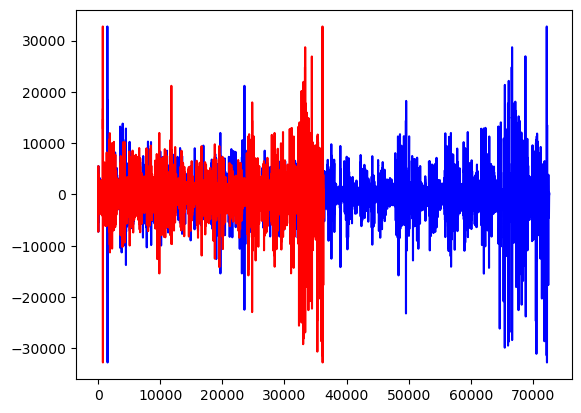

In [59]:

array = features[1][0]
ar = features[1][0]
pp.plot(ar,color='blue')
ar2 = ar
index = np.arange(0,len(ar2),2)
ar2 = np.delete(ar2, index)
pp.plot(ar2,color='red')
pp.show()

In [45]:
print("1D signal size :",len(ar))


1D signal size : 72640


1D signal size : 36320


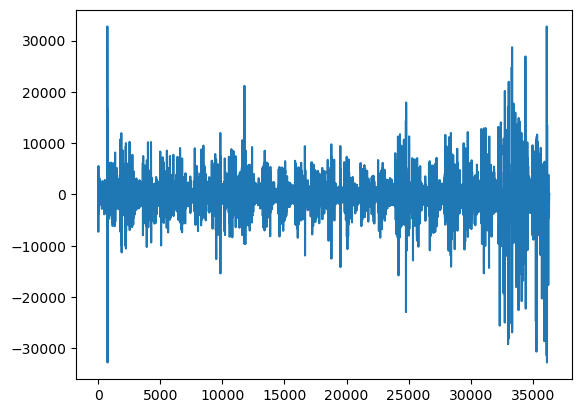

In [46]:
index = np.arange(0,len(ar),2)
ar = np.delete(ar, index)
print("1D signal size :",len(ar))
pp.plot(ar)
pp.show()

1D signal size : 141


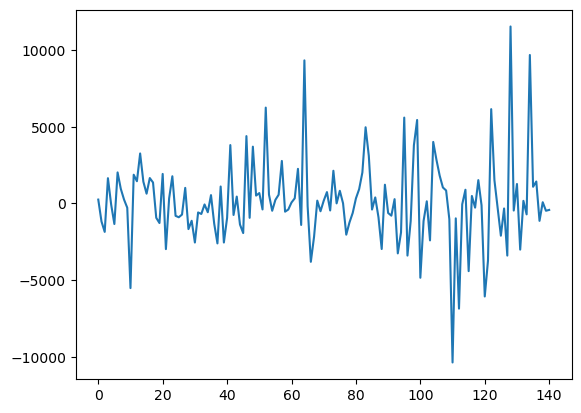

In [54]:
index = np.arange(0,len(ar),2)
ar = np.delete(ar, index)
print("1D signal size :",len(ar))
pp.plot(ar)
pp.show()

## Récupération d'un seul signal brut par patient

In [1]:
def create_train_test_1_recording(data_f):
    # Find the patient data files.
    patient_files = find_patient_files(data_f)
    num_patient_files = len(patient_files)
    
    murmur_classes = ['Present', 'Absent']
    num_murmur_classes = len(murmur_classes)
    features = list()
    murmurs = list()
    #outcomes = list()
    for i in range(109):
        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files[i])
        current_recordings = load_recordings_AV(data_folder, current_patient_data)
    
        # Extract features.
        #current_features = get_features_wav(current_patient_data,current_recordings)
        current_features = current_recordings # we keep only one arbitrary recording
        

        # Extract labels and use one-hot encoding.
        #current_murmur = np.zeros(num_murmur_classes, dtype=int)
        current_murmur = 0
        murmur = get_murmur(current_patient_data)
        #if murmur in murmur_classes:
        if murmur == "Present":
            #j = murmur_classes.index(murmur)
            #current_murmur[j] = 1
            current_murmur=1
        
        # Takes only in account patient that have a "Present" or "Absent" murmur.
        if murmur != "Unknown" and len(current_recordings)!=0:
            murmurs.append(current_murmur)
            features.append(current_features)
    

    #features = np.vstack(features)
    #murmurs = np.vstack(murmurs)


    X_train, X_test, y_train, y_test = train_test_split(features, murmurs, test_size=0.15)
    return X_train, X_test, y_train, y_test

    
    
    


In [2]:
X_train, X_test, y_train, y_test = create_train_test_1_recording(data_folder)

NameError: name 'data_folder' is not defined

In [3]:
def get_max_val(array):
    max = -10000
    for elem in array : 
        if np.max(elem) > max :
            max = np.max(elem)
    return max

def get_min_val(array):
    min = 10000
    for elem in array : 
        if np.min(elem) < min :
            min = np.min(elem)
    return min

def normalize_data(array,max,min):
    new_array = []
    for i in range(len(array)):
        new_signal = (max - array[i])/(max-min)
        new_array.append(new_signal)
    return new_array

In [4]:
max = get_max_val(X_train)
min = get_min_val(X_train)
X_train = normalize_data(X_train,max,min)


NameError: name 'X_train' is not defined

In [64]:
X_train

[array([[ 32419.,  32609., -32730., ..., -31710.,  30422.,  28828.]]),
 array([[-32648., -32544., -32673., ...,  32563.,  32494.,  32374.]]),
 array([[ 32556.,  32579.,  32638., ..., -32085., -32233., -32281.]]),
 array([[ 32596., -32403., -31174., ..., -32752., -32574., -32570.]]),
 array([[ 32539.,  32736., -32636., ..., -32413., -32752.,  32323.]]),
 array([[-27527., -30565.,  31493., ..., -32674.,  32741.,  32757.]]),
 array([[-32767.,  32765.,  32629., ...,  26819.,  27067.,  29573.]]),
 array([[-32523., -32656., -32687., ...,  10984.,  23851., -31280.]]),
 array([[-29225., -20916., -20578., ..., -32637., -32587., -32637.]]),
 array([[ 32466.,  32691., -32091., ..., -29082., -28856., -28783.]]),
 array([[-32574.,  32303., -30845., ..., -32593., -32295.,  32684.]]),
 array([[-24087.,  22452.,   9117., ...,  29883.,  30415.,  31529.]]),
 array([[-30653., -30556., -31412., ..., -32533.,  32633., -32496.]]),
 array([[31069., 31581., 31298., ..., 32526., 32015., 31623.]]),
 array([[-32

KeyboardInterrupt: 

In [13]:
final = np.array(X_train)

/var/folders/6b/chf9tnm540g1dftgb367hcx00000gn/T/ipykernel_59800/2235575205.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final = np.array(X_train)


In [27]:
#final
#max(map(max,X_train))
#final.argmax()


TypeError: 'numpy.int16' object is not callable

In [10]:
from sklearn import preprocessing
for i in range(len(X_train)):
    X_train[i] = preprocessing.minmax_scale(X_train[i])
print(X_train)

[array([0.51128172, 0.5100802 , 0.50491527, ..., 0.51070437, 0.51607215,
       0.51811628]), array([0.83702964, 0.77419751, 0.57789894, ..., 0.5006297 , 0.50929197,
       0.48911074]), array([0.5049186 , 0.4910845 , 0.49325523, ..., 0.50484969, 0.50076665,
       0.50030149]), array([0.5110399 , 0.49483482, 0.49419394, ..., 0.56324102, 0.569131  ,
       0.57232013]), array([0.49437705, 0.49629969, 0.52268254, ..., 0.41417563, 0.41219196,
       0.41524376]), array([0.51549554, 0.51213855, 0.50273899, ..., 0.50057221, 0.5011368 ,
       0.49935149]), array([0.30695048, 0.34193942, 0.42496376, ..., 0.52750439, 0.57608911,
       0.59017319]), array([0.48418796, 0.48953173, 0.48706287, ..., 0.49076616, 0.49648351,
       0.47978625]), array([0.491107  , 0.41228234, 0.44900727, ..., 0.51063938, 0.50833347,
       0.50999508]), array([0.49538415, 0.49881743, 0.51032273, ..., 0.55623713, 0.55968566,
       0.56079957]), array([0.5016556 , 0.5026627 , 0.5020676 , ..., 0.48818189, 0.4874647

In [35]:
print(len(X_train))
print(len(y_train))

85
85


In [36]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, padding="post"
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1764)
X_train = np.vstack(X_train)
X_valid = np.vstack(X_valid)
y_train = np.vstack(y_train)
y_valid = np.vstack(y_valid)


In [37]:
print(len(X_train[0]))
print(len(X_train[1]))
X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
X_valid = X_valid.reshape(len(X_valid),len(X_valid[1]),1)
y_train = y_train.reshape(len(y_train),1)
y_valid = y_valid.reshape(len(y_valid),1)

152384
152384


In [38]:
print(X_train.shape)
print(y_train.shape)


(70, 152384, 1)
(70, 1)


In [39]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2 
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise 
    return series[..., np.newaxis].astype(np.float32)


In [40]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [46]:
def one_recording_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=((152384,1))),
        tf.keras.layers.Masking(mask_value=0),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
    
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.GlobalAveragePooling1D(),

        #tf.keras.Input(shape=((152384,1))),
        #tf.keras.layers.Conv1D(6, kernel_size=(3,),activation='relu'),
        #tf.keras.layers.Conv1D(64, kernel_size=(3,), activation='relu'),
        #tf.keras.layers.MaxPool1D(pool_size=(3,), strides=2, padding='same'),
        #tf.keras.layers.Dense(64, activation='relu'),
        #tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Flatten(),
        #tf.keras.layers.LSTM(10),

        tf.keras.layers.Dense(1, activation='softmax') 
    ])
    return model


In [47]:
model = one_recording_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
history = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size = 32,
    validation_data=(X_valid, y_valid), 
    epochs=3
)

Epoch 1/3
3/3 [==============================] - 743s 245s/step - loss: 0.6961 - accuracy: 0.3857 - val_loss: 0.6898 - val_accuracy: 0.3333
Epoch 2/3


85


In [8]:
# Splitting dataset into train set, validation set and test set.
X_train, X_test, y_train, y_test = create_train_valtest_set(data_folder,verbose)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
y_train = np.vstack(y_train)
y_test = np.vstack(y_test)

Finding data files...
Extracting features and labels from the Challenge data...
    1/942...
    2/942...
    3/942...
    4/942...
    5/942...
    6/942...
    7/942...
    8/942...
    9/942...
    10/942...
    11/942...
    12/942...
    13/942...
    14/942...
    15/942...
    16/942...
    17/942...
    18/942...
    19/942...
    20/942...
    21/942...
    22/942...
    23/942...
    24/942...
    25/942...
    26/942...
    27/942...
    28/942...
    29/942...
    30/942...
    31/942...
    32/942...
    33/942...
    34/942...
    35/942...
    36/942...
    37/942...
    38/942...
    39/942...
    40/942...
    41/942...
    42/942...
    43/942...
    44/942...
    45/942...
    46/942...
    47/942...
    48/942...
    49/942...
    50/942...
    51/942...
    52/942...
    53/942...
    54/942...
    55/942...
    56/942...
    57/942...
    58/942...
    59/942...
    60/942...
    61/942...
    62/942...
    63/942...
    64/942...
    65/942...
    66/942...
    6

In [9]:
imputer_train = SimpleImputer().fit(X_train)
X_train = imputer_train.transform(X_train)

In [10]:
imputer_test = SimpleImputer().fit(X_test)
X_test = imputer_test.transform(X_test)


In [17]:
def murmur_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(,)),
        #tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax') 
    ])
    return model

def exp_decay(lr0, s):
    def exp_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exp_decay_fn

In [14]:

model = murmur_model()

2023-02-17 16:59:57.783269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
METRICS = [tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.CategoricalAccuracy(name='acc')]


model.compile(
optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=METRICS
)

In [18]:
exp_decay_fn = exp_decay(0.01, 20)
lrng_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(exp_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_file.h5",save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

EPOCHS = 10
history_audio_data_only = model.fit(
x=X_train,
y=y_train,
validation_split=0.1764,
callbacks=[checkpoint_cb, early_stopping_cb, lrng_rate_scheduler],
epochs=EPOCHS
)

Epoch 1/10
20/20 [==============================] - 4s 64ms/step - loss: 0.8428 - auc: 0.7521 - acc: 0.7332 - val_loss: 490.9802 - val_auc: 0.7160 - val_acc: 0.7481 - lr: 0.0100
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6232 - auc: 0.7949 - acc: 0.7676 - val_loss: 0.7747 - val_auc: 0.7698 - val_acc: 0.8092 - lr: 0.0089
Epoch 3/10
20/20 [==============================] - 0s 15ms/step - loss: 0.5479 - auc: 0.8137 - acc: 0.7840 - val_loss: 0.6074 - val_auc: 0.7751 - val_acc: 0.8092 - lr: 0.0079
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.5124 - auc: 0.8235 - acc: 0.7921 - val_loss: 0.5200 - val_auc: 0.7860 - val_acc: 0.8092 - lr: 0.0071
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 0.5077 - auc: 0.8293 - acc: 0.7823 - val_loss: 0.4939 - val_auc: 0.8059 - val_acc: 0.8092 - lr: 0.0063
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.4993 - auc: 0.8329 - acc: 0.7889 - val_loss

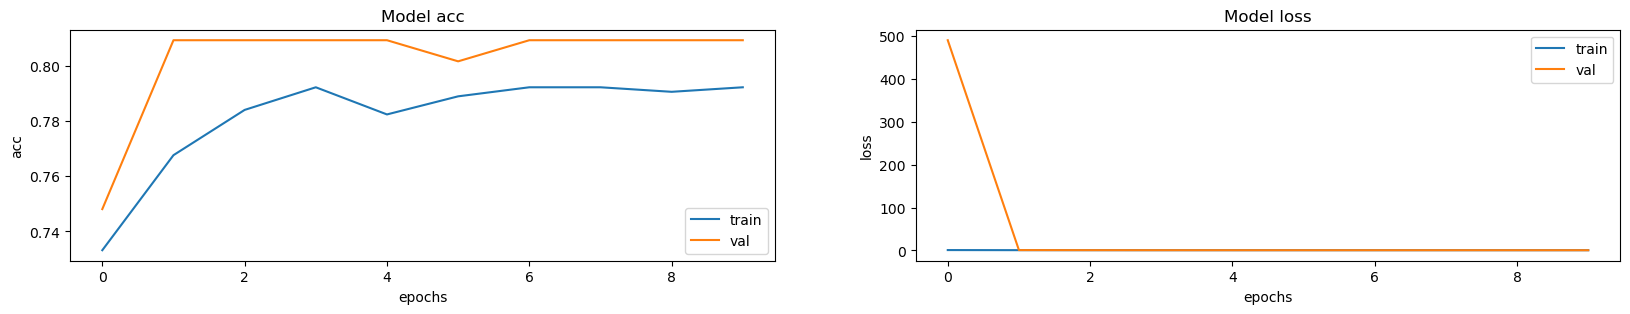

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_audio_data_only.history[met])
    ax[i].plot(history_audio_data_only.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
y_pred = model.predict(X_test)



5/5 [==============================] - 0s 3ms/step


In [24]:
#print(y_pred)
y_pred = np.around(y_pred)





In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("AUC:",metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.7954545454545454
AUC: 0.5


# Modèle appliqué aux données audio et du fichier csv